In [ ]:
!nvidia-smi

In [ ]:
!pip install -q ultralytics roboflow

In [ ]:
!yolo task=detect mode=train model=E:\projects\FootbalRoboflow\yolo11n.pt data=E:\projects\FootbalRoboflow\football\data.yaml batch=10 epochs=50 imgsz=1280 plots=True

In [ ]:
!yolo task=detect mode=val model=E:\projects\FootbalRoboflow\runs\detect\train\weights\best.pt data=E:\projects\FootbalRoboflow\football\data.yaml imgsz=1280

In [ ]:
!pip install -q supervision

In [ ]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [ ]:
from ultralytics import YOLO

model = YOLO('runs/detect/train/weights/best.pt')

result = model(source='download_3.mp4', show=False, conf=0.4, save=True)

In [ ]:
from ultralytics import YOLO
from tqdm import tqdm
import supervision as sv

# Initialize the YOLO model
yolo_model = YOLO("E:/projects/FootbalRoboflow/runs/detect/train/weights/best.pt")

# Annotators
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

SOURCE_VIDEO_PATH = "E:/projects/FootbalRoboflow/download_3.mp4"
TARGET_VIDEO_PATH = "E:/projects/FootbalRoboflow/download_result.mp4"

# Frame generator from supervision
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = yolo_model(frame, conf=0.4, save=False)[0]

        detections = sv.Detections.from_ultralytics(results)

        # Create labels
        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence in zip(detections['class_name'], detections.confidences)
        ]

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
        video_sink.write_frame(annotated_frame)


In [ ]:
from ultralytics import YOLO
from tqdm import tqdm
import supervision as sv

BALL_ID = 0
# Initialize the YOLO model
yolo_model = YOLO("E:/projects/FootbalRoboflow/runs/detect/train/weights/best.pt")

# Annotators
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20,
    height=17,
)

SOURCE_VIDEO_PATH = "E:/projects/FootbalRoboflow/download_3.mp4"
TARGET_VIDEO_PATH = "E:/projects/FootbalRoboflow/download_result2.mp4"

# Frame generator from supervision
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = yolo_model(frame, conf=0.4, save=False)[0]

        detections = sv.Detections.from_ultralytics(results)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nmm(threshold=0-5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id - 1

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        video_sink.write_frame(annotated_frame)


Collect Crops Of Players

In [ ]:
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm

STRIDE = 30
PLAYER_ID = 2

def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)
    yolo_model = YOLO("E:/projects/FootbalRoboflow/runs/detect/train/weights/best.pt")

    crops = []
    for frame in tqdm(frame_generator, desc="Extracting crops..."):
        results = yolo_model(frame, conf=0.3, save=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        detections = detections[detections.class_id == PLAYER_ID]
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        crops += [
            sv.crop_image(frame, xyxy)
            for xyxy in detections.xyxy
        ]
    return crops


In [ ]:
crops = extract_crops("E:/projects/FootbalRoboflow/download.mp4")

In [18]:
len(crops)

508

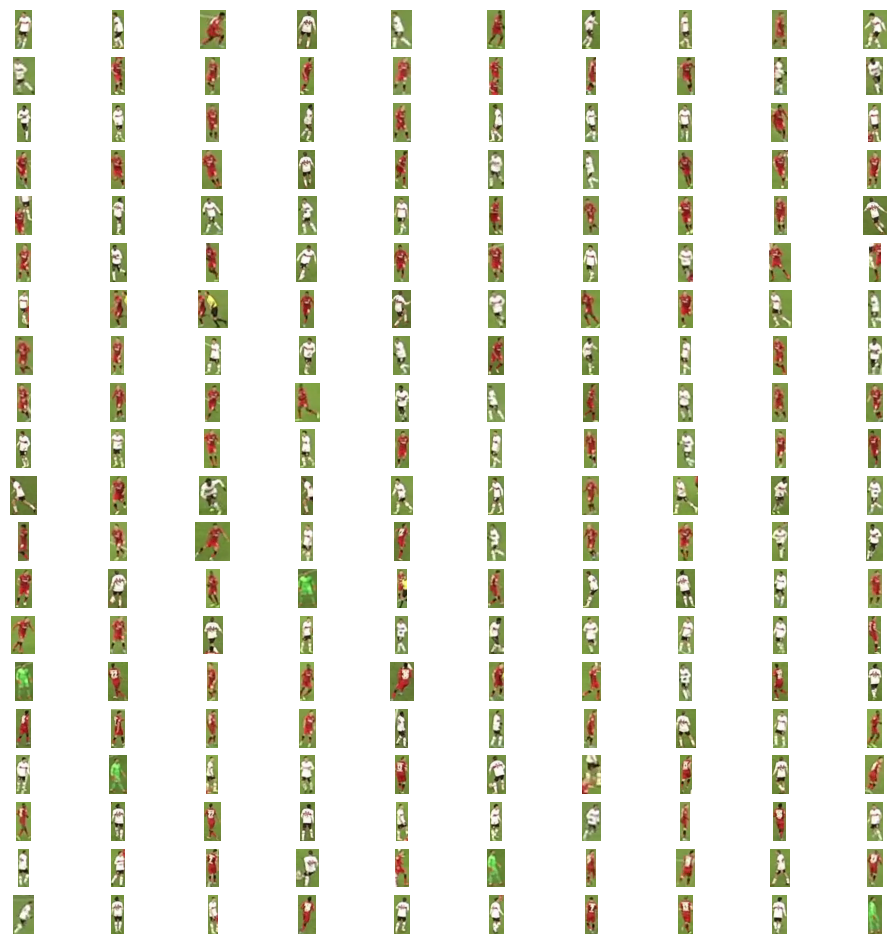

In [20]:
sv.plot_images_grid(crops[:200], grid_size=(20, 10))